The NOAA HRRR is a real-time 3km resolution, hourly updated, cloud-resolving, convection-allowing atmospheric model, initialized by 3km grids with 3km radar assimilation.

This notebook provides an example of accessing HRRR data, including (1) finding the data file corresponding to a date and time, (2) retrieving a portion of that file from blob storage which includes the surface temperature variable, (3) opening the file using the xarray library, and (4) rendering an image of the forecast.

This dataset is documented at http://aka.ms/ai4edata-hrrr.

In [119]:
import io
from datetime import date, timedelta

import xarray as xr
import requests
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import cmocean

# Not used directly, but used via xarray
import cfgrib

In [120]:
# Constants for creating the full URL
blob_container = "https://noaahrrr.blob.core.windows.net/hrrr"
sector = "conus"
yesterday = date.today() - timedelta(days=1)
cycle = 12          # noon
forecast_hour = 1   # offset from cycle time
product = "wrfsfcf" # 2D surface levels

# Put it all together
file_path = f"hrrr.t{cycle:02}z.{product}{forecast_hour:02}.grib2"
url = f"{blob_container}/hrrr.{yesterday:%Y%m%d}/{sector}/{file_path}"

print(url)

https://noaahrrr.blob.core.windows.net/hrrr/hrrr.20230124/conus/hrrr.t12z.wrfsfcf01.grib2


In [121]:
(yesterday)

datetime.date(2023, 1, 24)

In [165]:
# Fetch the idx file by appending the .idx file extension to our already formatted URL
r = requests.get(f"{url}.idx")
idx = r.text.splitlines()

# Take a peek at the content of the index
print(*idx[1:150], sep="\n")

2:309576:d=2023012412:RETOP:cloud top:1 hour fcst:
3:458385:d=2023012412:var discipline=0 center=7 local_table=1 parmcat=16 parm=201:entire atmosphere:1 hour fcst:
4:902674:d=2023012412:VIL:entire atmosphere:1 hour fcst:
5:1135417:d=2023012412:VIS:surface:1 hour fcst:
6:2556391:d=2023012412:REFD:1000 m above ground:1 hour fcst:
7:2749634:d=2023012412:REFD:4000 m above ground:1 hour fcst:
8:2844965:d=2023012412:REFD:263 K level:1 hour fcst:
9:2999675:d=2023012412:GUST:surface:1 hour fcst:
10:4288602:d=2023012412:UGRD:250 mb:1 hour fcst:
11:5065247:d=2023012412:VGRD:250 mb:1 hour fcst:
12:5791980:d=2023012412:UGRD:300 mb:1 hour fcst:
13:6564212:d=2023012412:VGRD:300 mb:1 hour fcst:
14:7299987:d=2023012412:HGT:500 mb:1 hour fcst:
15:8043354:d=2023012412:TMP:500 mb:1 hour fcst:
16:8594082:d=2023012412:DPT:500 mb:1 hour fcst:
17:9522074:d=2023012412:UGRD:500 mb:1 hour fcst:
18:10114741:d=2023012412:VGRD:500 mb:1 hour fcst:
19:10697373:d=2023012412:HGT:700 mb:1 hour fcst:
20:11449234:d=20230

In [123]:
# You can see it has a 1-indexed base line number, staring byte position, date, variable, atmosphere level,
# and forecast description. The lines are colon-delimited. 

# Let's grab surface temperature `TMP:surface`.
sfc_temp_idx = [l for l in idx if ":TMP:surface" in l][0].split(":")
print("Surface temp line:", sfc_temp_idx)

# Pluck the byte offset from this line, plus the beginning offset of the next line
line_num = int(sfc_temp_idx[0])
range_start = sfc_temp_idx[1]

# The line number values are 1-indexed, so we don't need to increment it to get the next list index,
# but check we're not already reading the last line
next_line = idx[line_num].split(':') if line_num < len(idx) else None

# Pluck the start of the next byte offset, or nothing if we were on the last line
range_end = next_line[1] if next_line else None

print(f"Byte range: {range_start}-{range_end}")

Surface temp line: ['64', '41107233', 'd=2023012412', 'TMP', 'surface', '1 hour fcst', '']
Byte range: 41107233-42500889


In [124]:
import tempfile
file = tempfile.NamedTemporaryFile(prefix="tmp_", delete=False)

headers = {"Range": f"bytes={range_start}-{range_end}"}
resp = requests.get(url, headers=headers, stream=True)

with file as f:
    f.write(resp.content)

In [125]:
print(tempfile.gettempdir())

/var/folders/4h/k9rc8jg13fxcn0m11yvndchr0000gn/T


In [126]:
ds = xr.open_dataset(file.name, engine='cfgrib', 
                     backend_kwargs={'indexpath':''})

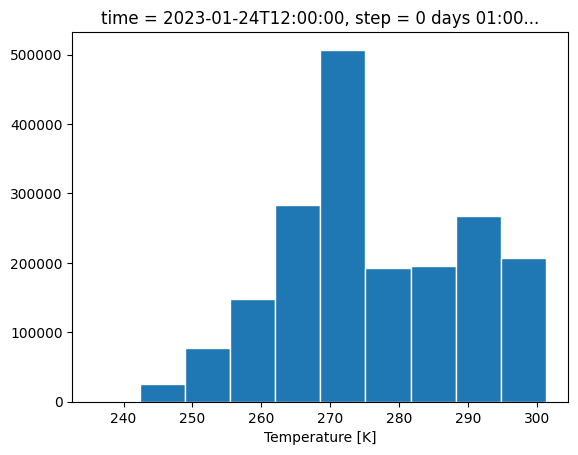

In [127]:
ds.t.plot.hist(edgecolor="white")
plt.show()

In [157]:
ds

<xarray.Dataset>
Dimensions:     (y: 1059, x: 1799)
Coordinates:
    time        datetime64[ns] 2023-01-24T12:00:00
    step        timedelta64[ns] 01:00:00
    surface     float64 0.0
    latitude    (y, x) float64 21.14 21.15 21.15 21.16 ... 47.86 47.85 47.84
    longitude   (y, x) float64 ...
    valid_time  datetime64[ns] 2023-01-24T13:00:00
Dimensions without coordinates: y, x
Data variables:
    t           (y, x) float32 294.6 294.6 294.6 294.6 ... 273.7 273.8 273.9
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    history:                 2023-01-25T15:27 GRIB to CDM+CF via cfgrib-0.9.1...

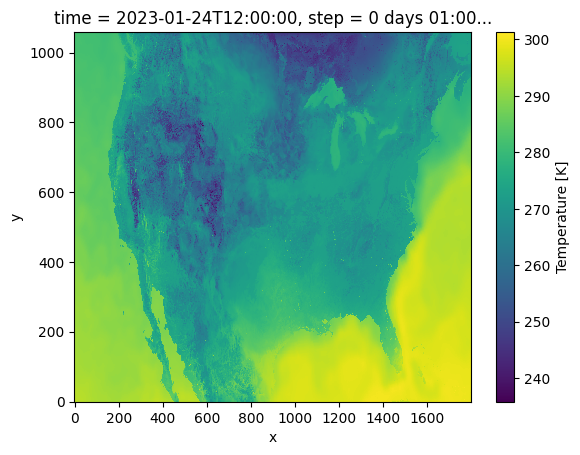

In [159]:
ds.t.plot()

In [164]:
ds.coords
#ds.t.attrs

Coordinates:
    time        datetime64[ns] 2023-01-24T12:00:00
    step        timedelta64[ns] 01:00:00
    surface     float64 0.0
    latitude    (y, x) float64 21.14 21.15 21.15 21.16 ... 47.86 47.85 47.84
    longitude   (y, x) float64 ...
    valid_time  datetime64[ns] 2023-01-24T13:00:00

In [155]:
ds.attrs

{'GRIB_edition': 2,
 'GRIB_centre': 'kwbc',
 'GRIB_centreDescription': 'US National Weather Service - NCEP',
 'GRIB_subCentre': 0,
 'Conventions': 'CF-1.7',
 'institution': 'US National Weather Service - NCEP',
 'history': '2023-01-25T15:27 GRIB to CDM+CF via cfgrib-0.9.10.3/ecCodes-2.27.0 with {"source": "../../../../../var/folders/4h/k9rc8jg13fxcn0m11yvndchr0000gn/T/tmp_vxt3ka7e", "filter_by_keys": {}, "encode_cf": ["parameter", "time", "geography", "vertical"]}'}

In [128]:
attrs = ds.t.attrs

assert attrs['GRIB_gridType'] == 'lambert'

# Define the CRS with attributes from the temperate DataArray
prj_kwargs = dict(
    globe=ccrs.Globe(ellipse='sphere'),
    central_latitude=attrs['GRIB_LaDInDegrees'],
    central_longitude=attrs['GRIB_LoVInDegrees'],
    standard_parallels=(attrs['GRIB_Latin1InDegrees'],\
                        attrs['GRIB_Latin2InDegrees'])
)

prj = ccrs.LambertConformal(**prj_kwargs)

In [97]:

ds.latitude

<xarray.DataArray 'latitude' (y: 1059, x: 1799)>
[1905141 values with dtype=float64]
Coordinates:
    time        datetime64[ns] 2023-01-24T12:00:00
    step        timedelta64[ns] 01:00:00
    surface     float64 0.0
    latitude    (y, x) float64 ...
    longitude   (y, x) float64 ...
    valid_time  datetime64[ns] 2023-01-24T13:00:00
Dimensions without coordinates: y, x
Attributes:
    units:          degrees_north
    standard_name:  latitude
    long_name:      latitude

In [146]:
import numpy as np
ds.t.sel(x=35,y=1)
latitude_array = ds.coords['latitude']
x, y = np.where(latitude_array == 39.080319)
print(x,y)

[] []


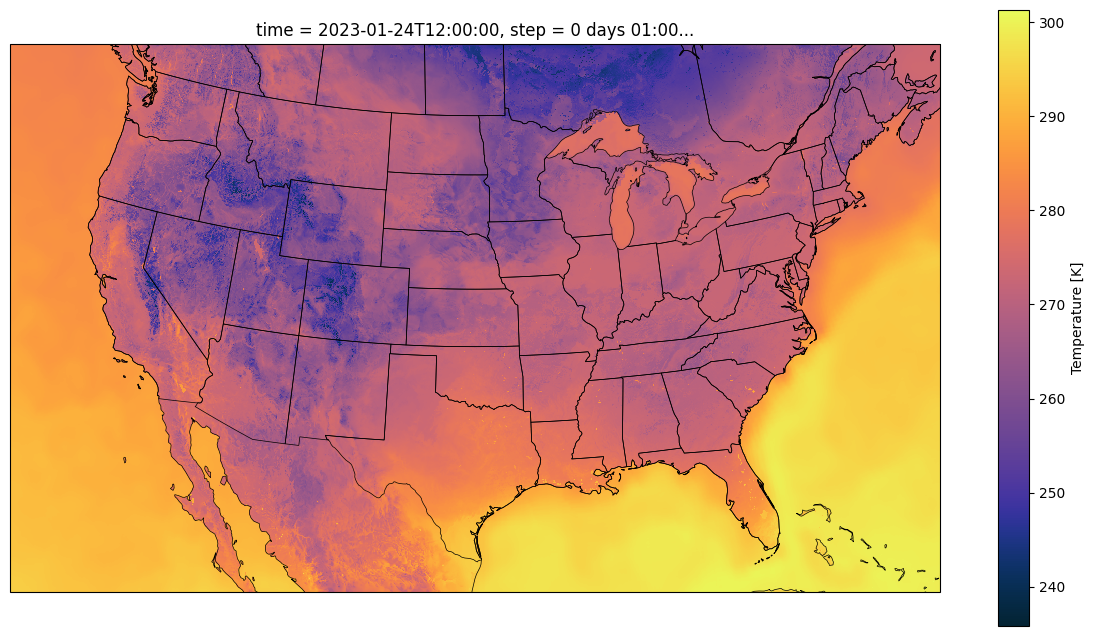

In [34]:
# Ignore some matplotlib deprecation warnings
import warnings; warnings.simplefilter("ignore")

fig = plt.figure(figsize=(15,8))
ax = plt.axes(projection=prj)
plt_kwargs = dict(x='longitude', y='latitude', cmap=cmocean.cm.thermal, 
                  transform=ccrs.PlateCarree())

ds.t.plot(**plt_kwargs, ax=ax)
ax.coastlines(linewidth=0.5)
ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.5)
plt.show()

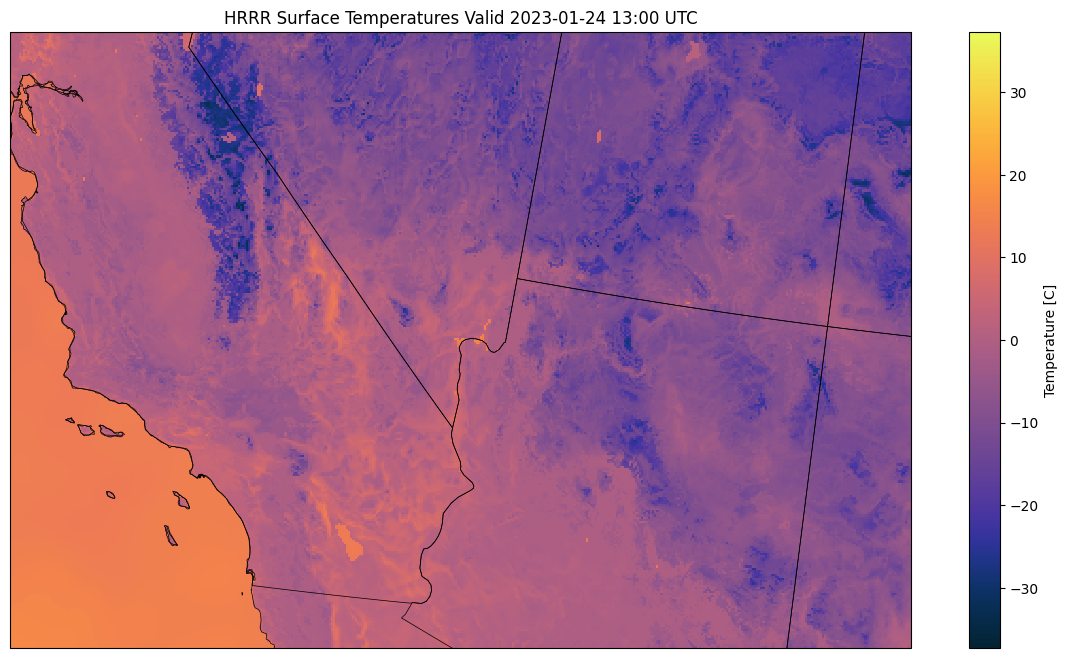

In [30]:
# Increase the dpi a bit for some crisper text
fig = plt.figure(figsize=(15,8), dpi=100)
ax = plt.axes(projection=prj)

# K to C
with xr.set_options(keep_attrs=True):
    t_c = ds.t - 273.15
    t_c.attrs["units"] = "C"

# Add some context and zoom to the SW
ax.coastlines(linewidth=0.5)
ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.5)
ax.set_extent([-121, -108, 33, 39], crs=ccrs.PlateCarree())

t_c.plot(**plt_kwargs, ax=ax)
d = ds.coords['valid_time'].values

plt.title(f"HRRR Surface Temperatures Valid {yesterday} {cycle + forecast_hour:02}:00 UTC")
plt.show()